In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from skimage.color import rgb2gray, gray2rgb
import tensorflow as tf
import glob
import os
from numpy.random import randint
from shutil import copyfile
from skimage.io import imread
from skimage.transform import resize
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import SGD
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [9]:
def read_dataset():
    # rozdeleni urceni slozek s trenovacimi a testovacimi daty
    train_dirs = ["./data_p1_fix_noise/train/field/", "./data_p1_fix_noise/train/animal/"]
    validation_dirs = ["./data_p1_fix_noise/validation/field/", "./data_p1_fix_noise/validation/animal/"]

    train_X = []
    train_Y = []
    class_num = 0
    for dirs in train_dirs:
        for file in glob.glob(dirs + "*.png"):
            # /255 = normalizace
            train_X.append(rgb2gray(imread(file)).reshape(32,32,1)/255)
            train_Y.append(class_num)
        class_num += 1

    validation_X = []
    validation_Y = []
    class_num = 0
    for dirs in validation_dirs:
        for file in glob.glob(dirs + "*.png"):
            validation_X.append(rgb2gray(imread(file)).reshape(32,32,1)/255)
            validation_Y.append(class_num)
        class_num += 1

    train_X = np.array(train_X)
    train_Y = to_categorical(np.array(train_Y), num_classes=2)
    validation_X = np.array(validation_X)
    validation_Y = to_categorical(np.array(validation_Y),num_classes=2)
    return train_X, train_Y, validation_X, validation_Y

In [10]:
def create_train_and_validation():
    # data rozdelena 70/30
    dir_positives = "./data_p1_fix_noise/positives/"
    dir_negatives = "./data_p1_fix_noise/negatives/"

    animal_files = glob.glob(dir_positives + "*.png")
    field_files = glob.glob(dir_negatives + "*.png")

    for file in animal_files:
        out_file = os.path.basename(file)
        if randint(0,3) != 0: #70% sance
            copyfile(file, "./data_p1_fix_noise/train/animal/"+out_file)
        else:
            copyfile(file, "./data_p1_fix_noise/validation/animal/"+out_file)

    for file in field_files:
        out_file = os.path.basename(file)
        if randint(0,3) != 0: #70% sance
            copyfile(file, "./data_p1_fix_noise/train/field/"+out_file)
        else:
            copyfile(file, "./data_p1_fix_noise/validation/field/"+out_file)

In [11]:
def plot_model(history):
    # Loss Curves
    plt.figure(figsize=[8, 6])
    plt.plot(history.history['loss'], 'r', linewidth=3.0)
    plt.plot(history.history['val_loss'], 'b', linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'], fontsize=18)
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.title('Loss Curves', fontsize=16)
    plt.savefig('pltLoss_part1_fix_noise_adam.png')

    # Accuracy Curves
    plt.figure(figsize=[8, 6])
    plt.plot(history.history['accuracy'], 'r', linewidth=3.0)
    plt.plot(history.history['val_accuracy'], 'b', linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=18)
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.title('Accuracy Curves', fontsize=16)
    plt.savefig('pltAcc_part1_fix_noise_adam.png')
    
    plt.show()

In [12]:
def make_model1():
    numClasses = 2
    input_shape = (32, 32, 1)
    model = tf.keras.models.Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(numClasses, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [15]:
def train_and_test():
    if not os.path.exists("./models/"):
        os.makedirs("./models/")
    model_name = './models/model_part1_fix_noise_adam'
    #if we have trained one, then load and update, if we haven't create it new from the architecture.
    if os.path.exists(model_name):
        model = load_model(model_name)
        print('model exists')
    else:
        model = make_model1()
    epochs = 2
    if not os.path.exists("./epochs/"):
        os.makedirs("./epochs/")
    #setup save call back and early stopping criteria.
    callbacks = [
                 tf.keras.callbacks.ModelCheckpoint('./epochs/{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', verbose=0, save_best_only=False,
                                    save_weights_only=False, mode='auto', save_freq='epoch'),
                 EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='auto')
                ]

    train_X, train_Y, validation_X, validation_Y = read_dataset()
    print(train_X.shape)

    history = model.fit(train_X, train_Y,
                        validation_data=(validation_X, validation_Y),
                        callbacks=callbacks,
                        epochs=epochs,
                        batch_size=64)

    model.save(model_name)

    plot_model(history)

In [ ]:
#pouze pokud jeste nejsou vytvorene, jinak zbytecne, akorat se prepisi
create_train_and_validation()

(28393, 32, 32, 1)
Epoch 1/2
444/444 [==============================] - 5s 9ms/step - loss: 0.0224 - accuracy: 0.9949 - val_loss: 9.4374 - val_accuracy: 0.5792
Epoch 2/2
444/444 [==============================] - 4s 8ms/step - loss: 0.0087 - accuracy: 0.9969 - val_loss: 0.0067 - val_accuracy: 0.9977
INFO:tensorflow:Assets written to: ./models/model_part1_fix_noise_adam\assets


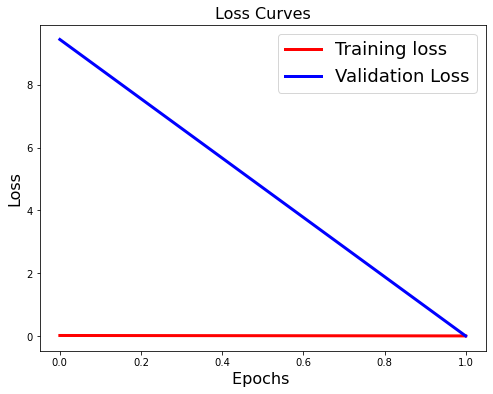

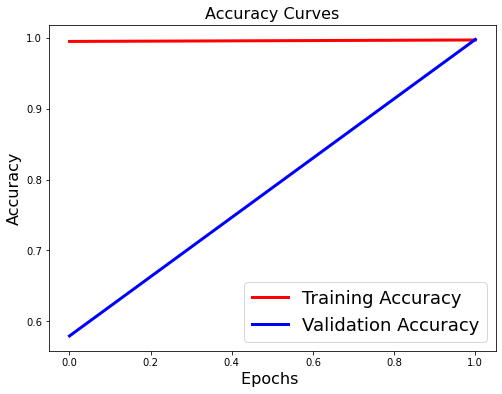

In [16]:
train_and_test()